# Deskriptive Analyse
Eine deskriptive Analyse des gesamten annotierten Datensets. (Paragraphen) Mit Fokus auf:
1. regionale vs. nationale Zeitungen
2. Ressorts
3. Anzahl der Paragraphen im Zeitverlauf
4. Länge der Paragraphen
5. Annotationen

Allgemeine Daten:
- Alle Artikel: 60'866'588
- Alle gefilterten Artikel ~25'000
- Alle annotierten Paragraphen: 1'268
- Alle annotierten Paragraphen mit relevantem Label: 127

### Import

In [1]:
# packages
import os
import re
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from ast import literal_eval
import plotly.graph_objects as go
import plotly.express as px
import json


In [2]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# change cwd
#cd drive/MyDrive/Work/Frontline/data
%cd /content/drive/MyDrive/data/

/content/drive/MyDrive/data


In [4]:
from scripts import annotations

In [5]:
data=pd.read_csv("annotated/all_annotations_06_13.csv", index_col=0,converters={"annotations":literal_eval})

In [6]:
data.loc[:,"annotations"]=data.apply(annotations.ground_truth_filter,min_coannotation=1,min_similarity=-1, similarity="dice",axis=1)

In [9]:
data=data[data.annotations!={"Domestic Violence"}]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 2 to 48
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   artikel_id       127 non-null    object 
 1   text             127 non-null    object 
 2   name             127 non-null    object 
 3   datum            127 non-null    int64  
 4   ressort          76 non-null     object 
 5   annotations      127 non-null    object 
 6   attributes_flat  101 non-null    object 
 7   file             127 non-null    object 
 8   artikel_order    64 non-null     float64
 9   jaccard          33 non-null     float64
 10  dice             33 non-null     float64
dtypes: float64(3), int64(1), object(7)
memory usage: 11.9+ KB


### Constants

In [8]:
regional_newspapers=['Aachener Nachrichten',
 'Aachener Zeitung',
 'Alb Bote',
 'Aller-Zeitung',
 'Allgemeine Zeitung Mainz-Rheinhessen',
 'Badische Zeitung',
 'Barmstedter Zeitung',
 'Bayerische Rundschau',
 'Bergedorfer Zeitung',
 'Bergische Morgenpost',
 'Berliner Kurier',
 'Berliner Morgenpost',
 'Berliner Zeitung',
 'Bersenbrücker Kreisblatt',
 'Bonner General-Anzeiger',
 'Bote vom Haßgau',
 'Bramscher Nachrichten',
 'Braunschweiger Zeitung',
 'Coburger Tageblatt',
 'DIE KITZINGER',
 'Darmstädter Echo',
 'Der Prignitzer',
 'Dresden am Wochenende',
 'Dresdner Morgenpost',
 'Dresdner Neueste Nachrichten',
 'Döbelner Allgemeine Zeitung',
 'Eichsfelder Tageblatt',
 'Ems-Zeitung',
 'Freie Presse',
 'Fränkischer Tag',
 'Gießener Anzeiger',
 'Göttinger Tageblatt',
 'Haller Tagblatt',
 'Hamburger Abendblatt',
 'Hamburger Morgenpost',
 'HarzKurier',
 'Heilbronner Stimme',
 'Hessische Niedersächsische Allgemeine',
 'Hildesheimer Allgemeine Zeitung',
 'Hochheimer Zeitung',
 'Hofheimer Zeitung',
 'Hohenloher Tagblatt',
 'Hohenzollerische Zeitung',
 'Husumer Nachrichten',
 'Höchster Kreisblatt',
 'Idsteiner Zeitung',
 'Kieler Nachrichten',
 'Kirner Zeitung',
 'Kreis-Anzeiger',
 'Lampertheimer Zeitung',
 'Landshuter Zeitung',
 'Lausitzer Rundschau - Elbe-Elster-Rundschau',
 'Lauterbacher Anzeiger',
 'Le Monde Diplomatique',
 'Leipziger Volkszeitung',
 'Lingener Tagespost',
 'Lübecker Nachrichten',
 'Magdeburger General-Anzeiger','Münsterland Zeitung',
 'Nahe Zeitung',
 'Nassauische Neue Presse',
 'Neue Osnabrücker Zeitung','Neue Ruhr/Rhein Zeitung',
 'Neue Westfälische',
 'Neue Württembergische Zeitung',
 'Neuss-Grevenbroicher Zeitung',
 'Neue Presse Hannover',
 'Magdeburger Volksstimme','Main-Post',
 'Main-Spitze','Nordbayerischer Kurier',
 'Norddeutsche Neueste Nachrichten',
 'Norddeutsche Rundschau','Nordkurier',
 'Nordwest-Zeitung',
 'Nürnberger Nachrichten','Oberhessische Zeitung',
 'Oeffentlicher Anzeiger',
 'Oschatzer Allgemeine Zeitung',
 'Osterländer Volkszeitung','Passauer Neue Presse',
 'Peiner Allgemeine Zeitung',
 'Reutlinger General-Anzeiger',
 'Rhein-Hunsrück-Zeitung',
 'Rhein-Lahn-Zeitung',
 'Rhein-Zeitung','Ruhr Nachrichten',
 'Rundschau für den Schwäbischen Wald',
 'Rüsselsheimer Echo',
 'Saale-Zeitung',
 'Saarbrücker Zeitung',
 'Salzgitter-Zeitung','Thüringische Landeszeitung',
 'Trierischer Volksfreund',
 'Usinger Anzeiger',
 'Volksblatt Würzburg',
 'Volkszeitung Schweinfurt'
 'Ostsee-Zeitung',
 'Ostthüringer Zeitung','Schweinfurter Tagblatt',
 'Schweriner Volkszeitung','Ostsee-Zeitung',
 'Volkszeitung Schweinfurt',
 'Westerwälder Zeitung',
 'Wiesbadener Kurier',
 'Wiesbadener Tagblatt',
 'Schwäbische Zeitung',
 'Segeberger Zeitung',
 'Solinger Morgenpost','Nürnberger Zeitung',
 'Straubinger Tagblatt',
 'Sächsische Zeitung',
 'Südkurier',
 'Taunus Zeitung','Wittlager Kreisblatt',
 'Wolfenbütteler Zeitung',
 'Wolfsburger Allgemeine Zeitung',
 'Wolfsburger Nachrichten',
 'Wormser Zeitung',
 'Thüringer Allgemeine',
 'Straubinger Tagblatt'
 'Nürnberger Zeitung',
 'Kölnische Rundschau']
national_newspapers=['Audio Video Foto Bild','Börsen-Zeitung','F.A.Z. Einspruch',
 'F.A.Z. Wirtschaftswissenschaft','FOCUS',
 'Frankfurter Neue Presse','Handelsblatt',
 'Handelsblatt Morning Briefing',"Jüdische Allgemeine","Süddeutsche Zeitung",
 'Frankfurter Rundschau',"Hannoversche Allgemeine Zeitung", 'ZEIT Campus',
 'ZEIT Studienführer',
 'ZEIT Wissen','Kölner Stadt-Anzeiger',
 'taz.die tageszeitung',"LiteraturSPIEGEL",
 'Christ und Welt','B.Z.',"BILD","BUSINESS INSIDER DEUTSCHLAND",'Spiegel Start',
 'Sport Bild', 'WELT KOMPAKT',
 'WELT ONLINE','Meller Kreisblatt',
 'Meppener Tagespost',
 'Metzinger Uracher Volksblatt',
 'Mittelbayerische Zeitung','Westfalen-Blatt',
 'Westfalenpost',
 'Mitteldeutsche Zeitung',"Wirtschaftszeitung",
 'WELT am SONNTAG',
 'Stern', "Märkische Allgemeine","SÜDWEST PRESSE",'Westdeutsche Allgemeine Zeitung',
 'Westdeutsche Zeitung','Le Monde Diplomatique',"Westfälische Rundschau","Rheinische Post",'Münchner Merkur',"BILD am Sonntag","Abendzeitung",'DIE ZEIT online','ZEIT Geschichte','DIE ZEIT', "DER SPIEGEL","DIE WELT","EXPRESS","taz","SPIEGEL Plus",'Bild der Frau','DER SPIEGEL online']


### 1. Regional vs. National

In [11]:
data.loc[:,"category"]=["regional" if name in regional_newspapers else "national" for name in data.name ]

In [12]:
fig=px.pie(names=list(data["category"].value_counts().keys()), title='Artikel zu Häuslicher Gewalt nach Kategorie: national/ regional',values=data["category"].value_counts())
fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)")
fig.show()

In [13]:
print("Anzahl der vorkommenden Zeitungen: ",data.name.nunique())
top=20
print(f"\nTop {top} der vorkommenden Zeitungen:\n")
round(data.name.value_counts(normalize=True)[:top].mul(100),2).astype(str)+" %"

Anzahl der vorkommenden Zeitungen:  41

Top 20 der vorkommenden Zeitungen:



BILD                               15.75 %
WELT ONLINE                        13.39 %
Hildesheimer Allgemeine Zeitung     5.51 %
Ruhr Nachrichten                    4.72 %
Coburger Tageblatt                  3.94 %
Wolfsburger Allgemeine Zeitung      3.94 %
Neue Ruhr/Rhein Zeitung             3.15 %
Schwäbische Zeitung                 3.15 %
Neue Presse Hannover                3.15 %
B.Z.                                3.15 %
Rhein-Hunsrück-Zeitung              3.15 %
Westdeutsche Allgemeine Zeitung     2.36 %
Mittelbayerische Zeitung            2.36 %
DIE WELT                            2.36 %
BILD am Sonntag                     2.36 %
Westfalenpost                       2.36 %
Berliner Morgenpost                 2.36 %
Hamburger Abendblatt                1.57 %
Sächsische Zeitung                  1.57 %
Barmstedter Zeitung                 1.57 %
Name: name, dtype: object

<Axes: >

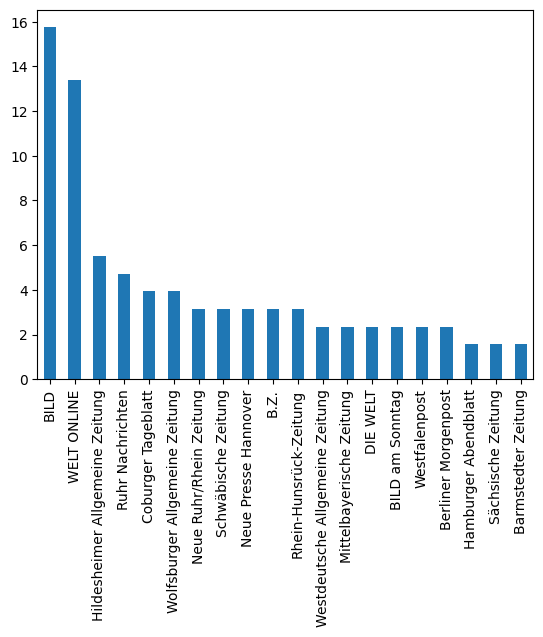

In [31]:
plot_newspapers = round(data.name.value_counts(normalize=True)[:top].mul(100),2)
plot_newspapers.plot.bar(x='lab', y='val', rot=90)

### 2. Ressorts

In [14]:
data.ressort=data.ressort.str.title()
ressort_rename={"PANORAMA":"Panorama","Titel":"Titelseite","Meinung Und Debatte":"Debatte","Aus Der Region":"Region",
                "Ausland":"Aus Aller Welt","Blick In Die Welt":"Aus Aller Welt","Antworten Und Debatte":"Debatte",
                "/Wn/Regiodesk Wb/Aus Aller Welt":"Aus Aller Welt","Rund Um Die Welt":"Aus Aller Welt", "Welt":"Aus Aller Welt","Weltspiegel":"Aus Aller Welt",
                "Welt Im Spiegel":"Aus Aller Welt",
                "Welt Aktuell":"Aus Aller Welt",
                "Deutschland":"Inland",
                "Land":"Inland",
                "F.A.Z. Einspruch":"Justiz",
                "Nrw Und Deutschland":"Inland"
}
data.ressort=data.ressort.replace(ressort_rename)


In [15]:
ressort_rename_regex={"[A-z +\&/\n,0-9;]*Lokal\S*[&äA-z \/]*":"Lokales",
                      "Ressort:\s":"",
                      "\S*[A-z \/\n]*Politik\S*[A-z \/\n]*":"Politik",
                      "\S*[A-z \&/\n]*Kultur\S*[A-z \/]*":"Kultur",
                      "Titel\S*[A-z \/]*":"Titelseite","\S*[A-z \&/\n]*Justiz\S*[&äA-z \/]*":"Justiz",
                      "\S*[A-z \&/\n]*Hintergrund\S*[&äA-z \/]*":"Hintergrund",
                      "\S*[A-z \&/\n]*Leser\S*[&äA-z \/]*":"Leser",
                      "\S*[A-z \&/\n]*Medien\S*[&äA-z \/]*":"Medien",
                      "\S*[A-z \&/\n]*Forum\S*[&äA-z \/]*":"Forum",
                      "[A-z +\&/\n,0-9\-;]*Meinung\S*[&äA-z \/]*":"Meinung",
                      "[A-z +\&/\n,0-9()Üß\-;]*Sport\S*[&äA-z \/]*":"Sport",
                      "[A-z ]*Aktuell\S*[&äA-z \/]*":"Aktuell",
                      "[A-z &ü\-]*Region\S*[\&\-äA-z \/]*":"Region",
                      "[A-z &ü\-]*region\S*[\&\-äA-z \/]*":"Region",
                      "[A-z &ü\-]*Panorama\S*[\&\-äA-z \/]*":"Panorama",


}
data.ressort=data.ressort.replace(ressort_rename_regex,regex=True)

In [16]:
data_ressort=data[["ressort"]]
data_ressort=data_ressort[data_ressort.ressort!=""]

In [17]:
print("Anzahl der vorkommenden Ressorts: ",data.ressort.nunique())

Anzahl der vorkommenden Ressorts:  19


In [18]:
fig = px.pie(names=data_ressort.ressort.value_counts(normalize=True).keys(), title='Artikel zu Häuslicher Gewalt nach Ressort\n',values=list(data_ressort.ressort.value_counts(normalize=True)))
fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)")
fig.show()

### 3. Anzahl der Artikel im Zeitverlauf

In [19]:
data.datum=data.datum.apply(pd.to_datetime,format="%Y%m%d")

In [20]:
data_grouped=data.groupby(["datum"]).count()["artikel_id"]
data_grouped=pd.DataFrame(data_grouped).reset_index().rename(columns={"artikel_id":"Veröffentlichte Artikel (pro Tag)", "datum":"Datum"})

In [21]:
data_grouped_monthly=data_grouped
data_grouped_monthly.Datum=[i +pd.offsets.MonthBegin(-1) for i in data_grouped_monthly.Datum]
data_grouped_monthly=data_grouped_monthly.groupby("Datum").sum().reset_index().rename(columns={"Veröffentlichte Artikel (pro Tag)":"Veröffentlichte Artikel (pro Monat)"})
fig = px.bar(data_grouped_monthly, y= "Veröffentlichte Artikel (pro Monat)",x="Datum", title='Veröffentlichte Artikel zum Thema Häusliche Gewalt',)
fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)")
fig.show()

In [22]:
data_grouped_res=data
data_grouped_res.datum=[i +pd.offsets.MonthBegin(-1) for i in data_grouped_res.datum]
data_grouped_res=data_grouped_res.groupby(["datum","ressort"]).count()[["artikel_id"]]
data_grouped_res=pd.DataFrame(data_grouped_res).reset_index().rename(columns={"artikel_id":"Veröffentlichte Artikel (pro Monat)", "datum":"Datum","ressort":"Ressort"})
fig = px.bar(data_grouped_res, y= "Veröffentlichte Artikel (pro Monat)",x="Datum", title='Veröffentlichte Artikel zum Thema Häusliche Gewalt',color="Ressort")
fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)")
fig.show()

In [23]:
data_grouped_cat=data
data_grouped_cat.datum=[i +pd.offsets.MonthBegin(-1) for i in data_grouped_cat.datum]
data_grouped_cat=data_grouped_cat.groupby(["datum","category"]).count()[["artikel_id"]]
data_grouped_cat=pd.DataFrame(data_grouped_cat).reset_index().rename(columns={"artikel_id":"Veröffentlichte Artikel (pro Monat)", "datum":"Datum","category":"Kategorie"})
fig = px.bar(data_grouped_cat, y= "Veröffentlichte Artikel (pro Monat)",x="Datum", title='Veröffentlichte Artikel zum Thema Häusliche Gewalt',color="Kategorie")
fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)")
fig.show()

### 4. Länge von Paragraphen
-> beachte: Paragrphen mit Überlänge (>120 Wörter) wurden rausgefiltert

In [24]:
data["lengths"]=[len(i.split()) for i in data.text]

In [25]:
fig=px.histogram(data.rename(columns={"category":"Kategorie"}),"lengths", nbins=50, title="Länge von Paragraphen zum Thema häusliche Gewalt", color="Kategorie")
fig.update_layout(yaxis_title="Anzahl der Artikel")
fig.update_layout(xaxis_title="Anzahl der Wörter eines Paragraphen")
fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)")
fig.show()

In [26]:
fig=px.bar(data.rename(columns={"lengths":"Länge"}).groupby("ressort")["Länge"].mean(),title="Länge der Paragraphen nach Ressort")
fig.update_layout(yaxis_title="Länge der Paragraphen (Wörter)")
fig.update_layout(xaxis_title="Ressorts")
fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)")
fig.show()

## 5. Annotationen

In [27]:
names=[list(i) for i in data.annotations.value_counts().keys()]

In [28]:
fig = px.pie(names=names, title='Labels der Annotierten Paragraphen',values=list(data.annotations.value_counts()))
fig.update_layout(paper_bgcolor = "rgba(0,0,0,0)",
                  plot_bgcolor = "rgba(0,0,0,0)")
fig.show()

In [29]:
data["annotations"]=[", ".join(list(ann)) for ann in data.annotations]

In [30]:
px.bar(data.groupby(["file","annotations"]).count()[["artikel_id"]].reset_index().rename(columns={"artikel_id":"Anzahl Paragraphen","annotations":"Annotationen"}),x="file",y="Anzahl Paragraphen",color="Annotationen",title="Annotationen nach Datenset")